공부 내용
- Supervised Fine Tuning
- Reward Model의 ranking algorithm 및 loss fuction 설계 원리
- 언어모델을 강화학습하기 위한 방법론

cloud shell에서 아래와 같이 KochatGPT를 설치    
    cd aiffel    
    git clone https://github.com/airobotlab/KoChatGPT     
    cd KoChatGPT/colossalai_ChatGPT_230319/    
    pip install .    

In [1]:
import torch

print("Torch version:{}".format(torch.__version__)) # Torch version:1.12.1
print("Cuda version: {}".format(torch.version.cuda)) # Cuda version: 11.3
!pip list | grep transformers # transformers 4.28.0

Torch version:1.12.1
Cuda version: 11.3
transformers                  4.28.0


#  Base model and Dataset for RLHF

 backbone 모델로 사용할 KoGPT-2의 성능 확인하기  
 허깅페이스의 transformers를 사용하여 토크나이저와 모델을 불러오기 

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
import numpy

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "skt/kogpt2-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


모델의 토크나이저가 입력받아 처리할 수 있는 최대 토큰 수를 확인하기

In [3]:
tokenizer.max_model_input_sizes

{'gpt2': 1024,
 'gpt2-medium': 1024,
 'gpt2-large': 1024,
 'gpt2-xl': 1024,
 'distilgpt2': 1024}

kogpt-2는 어떻게 토크나이징을 하는지 확인하기

In [4]:
input_txt = "바람도 없는 공중에 수직의 파문을 내이며 고요히 떨어지는 오동잎은 누구의 발자취 입니까."

In [5]:
tokens = tokenizer(input_txt).tokens()
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].numpy()

In [6]:
pd.options.display.max_columns = 40
pd.options.display.max_rows = 60
df = pd.DataFrame([tokens, input_ids[0]], index=["kogpt-2_tokens", "Input_IDs"])
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
kogpt-2_tokens,▁바람,도,▁없는,▁공중에,▁수직,의,▁파,문을,▁내,이며,▁고,요,히,▁떨어지는,▁오동,잎은,▁누,구의,▁발자,취,▁입,니까,.
Input_IDs,10891,7235,9712,49207,14438,8143,9203,9941,9094,9639,9065,8084,8811,21215,34769,19985,9669,10139,21626,8408,9241,23775,389


디코딩 성능도 확인하기   
시퀀스 반복 출력은 그리디 서치 디코딩시 발견되는 전형적인 현상이다.

In [7]:
max_length=128
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_greedy = model.generate(input_ids, 
                               max_length=max_length, 
                               do_sample=False)
print(tokenizer.decode(output_greedy[0]))

바람도 없는 공중에 수직의 파문을 내이며 고요히 떨어지는 오동잎은 누구의 발자취 입니까.'
"그렇다면 그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리요?"
"그건 무슨 소리


이번엔 빔 서치 디코딩을 사용하고 n-gram 패널티까지 부과해보기  
입력 시퀀스와 별 상관 없어 보이는 긴 문단이 생성이 되는 것을 확인 할 수 있음

In [8]:
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_beam = model.generate(input_ids, max_length=max_length, num_beams=10, no_repeat_ngram_size=2,
                             do_sample=False)
print(tokenizer.decode(output_beam[0]))

바람도 없는 공중에 수직의 파문을 내이며 고요히 떨어지는 오동잎은 누구의 발자취 입니까.'
"그렇지 않습니다."
"어떻게 된 일입니까?"
그녀는 고개를 갸웃거렸다.
"아니, 그게 무슨 말씀이신지 모르겠습니다만."
"무슨 말씀인지 알 수가 없군요."
아무런 대답도 하지 않은 채 그녀는 고개를 끄덕였다.
"그래, 알았어."
그녀의 눈에서 눈물이 주르륵 흘러내렸다.
그녀가 다시 입을 열었다.
"정말 죄송합니다, 고마워요, 고맙습니다"
"


샘플링 기법까지 추가해 보기

In [9]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=7, no_repeat_ngram_size=2,
                             do_sample=True, temperature=2.0, top_k=50)
print(tokenizer.decode(output_beam[0]))

바람도 없는 공중에 수직의 파문을 내이며 고요히 떨어지는 오동잎은 누구의 발자취 입니까.'
"하하, 그게 뭔 말씀이세요?"
"어떻게 해서 그런지 모르겠구만. 어쩐 일인지 오늘은 그런 게 없는 것 같습니다."
그는 고개를 저으며 말했다.
"뭐라고 하는 것이 더 좋을지."
"아! 그걸 누가 알면 어떻게 알겠습니까."
그는 눈을 깜박이며 그 말에 귀를 기울이는 것 같았다.
"허허. 이 녀석 좀 봐줘. 나하고 상관없는 일로 오해를 사겠어."
그의 말에 그는 고개를 끄


top_p 샘플링 기법도 사용해보기

In [10]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=7, no_repeat_ngram_size=2,
                             do_sample=True, top_p=0.90)
print(tokenizer.decode(output_beam[0]))

바람도 없는 공중에 수직의 파문을 내이며 고요히 떨어지는 오동잎은 누구의 발자취 입니까.'
"그런데 무슨 일입니까?"
"글쎄요, 그게 무슨 말씀이십니까, 선생님."
"선생님, 저는 선생님의 말씀을 듣고 싶지 않습니다. 선생님이 저에게 말씀하실까요? 선생님은 저를 잘 알고 계실 겁니다. 선생님을 잘 알지도 못하시는 분이시니까요."
선생님은 고개를 끄덕였다.
"아니오. 그건 말씀드리지 않으셔도 됩니다."
그녀는 고개를 저었다.
"그래


베이스라인 모델로 사용한 kogpt-2의 일반적인 성능을 확인해봤으니
구체적인 instruction과 prompting을 사용해 어떻게 디코딩을 해내는지도 확인해보면 좋겠다

## 데이터 셋 확인
SFT를 시도할 initial 모델에 쓸 데이터셋을 살펴보기

In [45]:
import json 
data_path_1_SFT = '/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_1_SFT.jsonl' 
with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file:
    list_data_dict_SFT = json.load(json_file)

print(len(list_data_dict_SFT))
list_data_dict_SFT[:3]

12000


[{'prompt': '불고기용 고기 한우에요?',
  'completion': "'저는 인공지능 챗봇이며, 직접적으로 식품에 관한 정보를 가지고 있지 않습니다. 하지만 일반적으로 불고기용 고기는 한우, 쇠고기, 돼지고기 등 다양한 종류의 고기를 사용합니다. 하지만 한우는 대표적인 고급 육류로 알려져 있기 때문에, 한우를 사용하는 경우도 많습니다. 알러지나 개별 건강 상태에 따라 다를 수 있으니 충분한 정보 수집 후에 선택해 주시기 바랍니다.",
  'tokens': 193},
 {'prompt': '쓰던 앱이 유료로 전환됐어',
  'completion': "'어떤 앱인지 모르기 때문에 정확한 답변을 드리기 어렵습니다. 하지만, 일반적으로 유료 전환된 앱은 기존 무료 앱에서 추가적인 기능이나 서비스를 제공하는 경우가 많습니다. 이 경우, 유료 전환 이전 가격이 매우 저렴하거나 무료인 경우가 많으므로, 앱을 계속 사용하려면 추가적인 비용을 지불해야 할 수 있습니다. 하지만, 유료 전환 이후에는 기존 사용자 또는 새로운 사용자 모두가 추가 기능과 높은 품질의 서비스를 이용할 수 있게 됩니다. 따라서, 앱 개발자는 유료 모델로 전환함으로써 앱의 수익을 증가시키고 더 나은 서비스를 제공할 수 있습니다.",
  'tokens': 288},
 {'prompt': '여친이랑 다툼',
  'completion': "'저는 인공지능이기 때문에 여친과의 다툼에 대해서는 조언을 드릴 수는 없습니다. 하지만 다투게 되면 상대방의 말을 경청하는 태도와 서로의 감정을 존중하는 것이 중요합니다. 논리적이고 차분한 대화를 통해 문제를 해결해보세요. 그리고 서로를 이해하고 서로의 의견을 수용하는 것이 중요합니다.",
  'tokens': 153}]

텍스트의 최소 길이 : 0
텍스트의 최대 길이 : 295
텍스트의 평균 길이 : 22.180583333333335
요약의 최소 길이 : 4
요약의 최대 길이 : 1553
요약의 평균 길이 : 144.10725


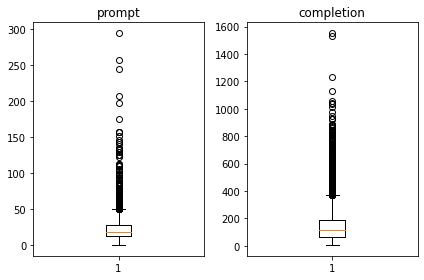

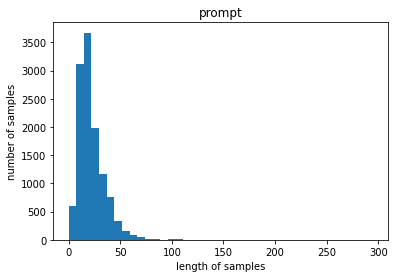

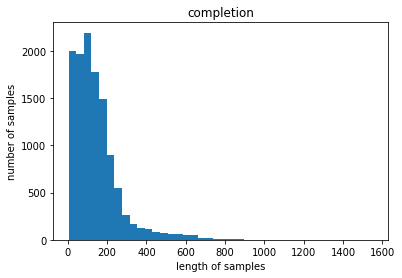

In [46]:
# 길이 분포 출력
import matplotlib.pyplot as plt
import numpy as np

prompt_len =[len(item['prompt']) for item in list_data_dict_SFT]
completion_len = [len(item['completion']) for item in list_data_dict_SFT]

print('텍스트의 최소 길이 : {}'.format(np.min(prompt_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(prompt_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(prompt_len)))
print('요약의 최소 길이 : {}'.format(np.min(completion_len)))
print('요약의 최대 길이 : {}'.format(np.max(completion_len)))
print('요약의 평균 길이 : {}'.format(np.mean(completion_len)))

plt.subplot(1,2,1)
plt.boxplot(prompt_len)
plt.title('prompt')
plt.subplot(1,2,2)
plt.boxplot(completion_len)
plt.title('completion')
plt.tight_layout()
plt.show()

plt.title('prompt')
plt.hist(prompt_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('completion')
plt.hist(completion_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
item['prompt'] for item in list_data_dict_SFT

In [52]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length([item['prompt'] for item in list_data_dict_SFT], 1)

헉
휴
후
네
음


In [57]:
check_sentence_with_length([item['prompt'] for item in list_data_dict_SFT], 0)

In [53]:
def find_indices_with_length(raw, length):
    indices = []
    for i, sen in enumerate(raw):
        if len(sen) == length:
            indices.append(i)
    return indices

find_indices_with_length([item['prompt'] for item in list_data_dict_SFT], 1)

[2976, 4217, 5811, 7080, 11045]

In [62]:
list_data_dict_SFT[11045]

{'prompt': '음',
 'completion': "'죄송합니다, 이전에 질문하신 내용이 불분명하여 대답을 드리지 못하였습니다. 더 자세한 내용을 알려주시면 최대한 빠르고 정확하게 답변 드리도록 하겠습니다. 감사합니다.",
 'tokens': 96}

In [54]:
find_indices_with_length([item['prompt'] for item in list_data_dict_SFT], 0)

[1983, 4793, 8222]

In [59]:
list_data_dict_SFT[1983]

{'prompt': '',
 'completion': "'Sorry, as an AI language model, I need more information about what you are asking. Please provide me with more context so that I can assist you better.",
 'tokens': 40}

In [60]:
list_data_dict_SFT[4793]

{'prompt': '',
 'completion': "'As an AI language model, I do not have a physical body or consciousness, so I do not experience emotions in the same way humans do. However, I am designed to understand and respond appropriately to emotional language and can provide empathetic responses to help simulate human-like interactions.",
 'tokens': 63}

In [56]:
def remove_data_at_indices(data, indices_to_remove):
    # 인덱스를 기반으로 데이터 삭제
    remaining_data = [data[i] for i in range(len(data)) if i not in indices_to_remove]
    return remaining_data

In [63]:
list_data_dict_SFT = remove_data_at_indices(list_data_dict_SFT, [1983, 4793, 8222, 2976, 4217, 5811, 7080, 11045])
len(list_data_dict_SFT)

11992

데이터의 개수가 12000에서 11992로 감소했다. 

# Supervised Fine-Tuning

## SFT
 kogpt-2를 instruction dataset으로 SFT를 진행해보기

In [66]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.optim import Adam
from datasets import load_dataset
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from transformers import Trainer, TrainingArguments
from copy import deepcopy
import copy
import logging
import json
from dataclasses import dataclass

모델과 토크나이저를 불러오기

In [67]:
model = AutoModelForCausalLM.from_pretrained('skt/kogpt2-base-v2')
tokenizer = AutoTokenizer.from_pretrained(
    'skt/kogpt2-base-v2', bos_token='</s>', eos_token='</s>', unk_token='</s>', pad_token='</s>',
    padding_side="right",
    model_max_length=512,
)

print(tokenizer)

GPT2TokenizerFast(name_or_path='skt/kogpt2-base-v2', vocab_size=51200, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '</s>'}, clean_up_tokenization_spaces=True)


모델 인퍼런스 단계에서 사용할 prompt 딕셔너리 템플릿과 SFT 데이터셋 클래스를 정의하기

In [68]:
from typing import Optional, Dict, Sequence

# Sequence-to-Sequence 모델을 학습하기 위한 데이터셋 클래스 정의
class SFT_dataset(Dataset): # Dataset 클래스를 상속받아 정의

    def __init__(self, data_path_1_SFT: str, tokenizer: transformers.PreTrainedTokenizer, verbose=False):
        super(SFT_dataset, self).__init__()
        
        # 데이터를 로드하는데 필요한 로그 및 패턴을 설정
        logging.warning("Loading data...")

        pattern_instruction = 'prompt'  # instruction
        pattern_output = 'completion'  # response
        
        '''
        # JSON 파일을 열고 데이터를 로드
        data_path_1_SFT = '/aiffel/KoChatGPT/data_kochatgpt/kochatgpt_1_SFT.jsonl'
        with open(data_path_1_SFT, "r", encoding='utf-8-sig') as json_file:
            list_data_dict = json.load(json_file)
        '''
        
        # 프롬프트에 대한 템플릿을 정의
        PROMPT_DICT = {
            "prompt_input": (
                "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
            )
        }

        prompt_input = PROMPT_DICT["prompt_input"]
        
        # 소스와 타겟 데이터를 구성
        sources = []
        for example in list_data_dict_SFT:
            tmp = prompt_input.format_map(example)
            sources.append(tmp)

        targets = []
        for example in list_data_dict_SFT:
            targets.append(f"{example[pattern_output]}{tokenizer.eos_token}")
        examples = [s + t for s, t in zip(sources, targets)]
        
        # 데이터를 토큰화
        sources_tokenized = self._tokenize_fn(sources, tokenizer)  # source
        examples_tokenized = self._tokenize_fn(examples, tokenizer)  # source + target

        input_ids = examples_tokenized["input_ids"]
        labels = copy.deepcopy(input_ids)
        for label, source_len in zip(labels, sources_tokenized["input_ids_lens"]):
            label[:source_len] = -100
        
        # 레이블을 설정
        data_dict = dict(input_ids=input_ids, labels=labels)

        self.input_ids = data_dict["input_ids"]
        self.labels = data_dict["labels"]
        
        # 데이터를 클래스 속성에 할당
        logging.warning("Loading data done!!: %d"%(len(self.labels)))

    
    # 문자열을 토큰화하여 딕셔너리 형태로 반환
    def _tokenize_fn(self, strings: Sequence[str], tokenizer: transformers.PreTrainedTokenizer) -> Dict:
        tokenized_list = [
            tokenizer(
                text,
                return_tensors="pt",
                padding="longest",
                max_length=tokenizer.model_max_length,
                truncation=True,
            )
            for text in strings
        ]
        input_ids = labels = [tokenized.input_ids[0] for tokenized in tokenized_list]
        input_ids_lens = labels_lens = [
            tokenized.input_ids.ne(tokenizer.pad_token_id).sum().item() for tokenized in tokenized_list
        ]
        return dict(
            input_ids=input_ids,
            labels=labels,
            input_ids_lens=input_ids_lens,
            labels_lens=labels_lens,
        )

    # 데이터셋의 총 길이를 반환
    def __len__(self):
        return len(self.input_ids)

    # 주어진 인덱스에 해당하는 데이터를 반환하는 메서드
    def __getitem__(self, i) -> Dict[str, torch.Tensor]:
        return dict(input_ids=self.input_ids[i], labels=self.labels[i])

데이터셋의 각 인스턴스를 처리하여 모델 학습에 필요한 형식으로 데이터를 준비하는 데이터 콜레이터(DataCollator) 클래스를 정의하기  
이 클래스는 데이터셋을 배치 단위로 처리할 때 사용된다

In [69]:
@dataclass # 데이터 클래스를 정의할 때 사용
class DataCollatorForSupervisedDataset(object): 

    tokenizer: transformers.PreTrainedTokenizer

    def __call__(self, instances: Sequence[Dict]) -> Dict[str, torch.Tensor]:
        input_ids, labels = tuple([instance[key] for instance in instances] for key in ("input_ids", "labels"))
        input_ids = torch.nn.utils.rnn.pad_sequence(
            input_ids, batch_first=True, padding_value=self.tokenizer.pad_token_id
        )
        labels = torch.nn.utils.rnn.pad_sequence(labels, batch_first=True, padding_value= -100)
        return dict(
            input_ids=input_ids,
            labels=labels,
            attention_mask=input_ids.ne(self.tokenizer.pad_token_id),
        )

SFT_dataset 클래스를 사용해 훈련셋을 만들고 data collator 인스턴스를 만들기

In [72]:
train_dataset = SFT_dataset(data_path_1_SFT=list_data_dict_SFT, tokenizer=tokenizer)
data_collator = DataCollatorForSupervisedDataset(tokenizer=tokenizer)

print('input : %s'%train_dataset.input_ids[0])
print('output: %s'%train_dataset.labels[0])

input : tensor([  739,   378,   378,   378, 14659, 13394, 37091, 10651,   383, 25841,
         8006, 14914,   375,  7673, 20479,  8091, 22311,  9036, 30902, 13675,
          375,   378,   378,   378, 41951,   454,  9549, 20549,   383,  8142,
         7192, 14914,   382, 37767, 13753,  8263,  7166,   739,  8352,  7659,
         9594, 25585, 13600,  8022,  9378, 11532,  9887, 11218,  9111, 16691,
        10351, 10561,  9128, 20479,  8091,  9065,  9446,  9036, 28420, 26521,
        10163, 26367,  6958,  9030,  9882, 12317, 25882,  9209, 37194, 10351,
         9036, 12168, 10529, 15989,  9719, 15434, 10552, 11188, 13362,  9036,
        15805, 11300, 11846,  9146, 16691,  9181,  7397, 15806, 13480, 11342,
        17596,  9161, 19996,  9025, 25006, 18595,  9966, 12592, 10751, 11814,
         8711,  9046, 12450,  9117,  7377, 12521,     1])
output: tensor([ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -10

-100은 패딩된 값

훈련을 위한 마지막 단계로 Training arguments를 사용해 trainer 클래스를 정의하기

Warmup 단계는 학습률을 조절하기 위한 기술 중 하나입니다.   
주로 Transformer 모델과 같은 대규모 모델을 학습할 때 사용됩니다.  
Warmup 단계에서는 초기에 학습률을 작게 시작하고, 일정 단계동안 서서히 증가시켜 모델의 안정적인 학습을 돕습니다.

In [73]:
training_args = TrainingArguments(
    output_dir="/aiffel/KoChatGPT/test", #  모델과 로그 파일의 출력 디렉토리 경로를 설정
    overwrite_output_dir=True, # 이전 출력 디렉토리를 덮어쓸지 여부를 결정
    num_train_epochs=1, # 학습할 epoch 수
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=5, # 학습률을 조절하기 위한 warmup 단계 수를 설정
    prediction_loss_only=True, #  평가 단계에서 예측 손실만 계산할지 여부를 결정
    fp16 = True # 16비트 부동 소수점을 사용하여 학습할지 여부를 설정
    )
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator, # 16비트 부동 소수점을 사용하여 학습할지 여부를 설정
    train_dataset=train_dataset
)

SFT 훈련을 진행해보기

In [74]:
trainer.train()
model.save_pretrained('/aiffel/KoChatGPT/output_1_SFT')

/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
500,2.970100
1000,2.774900


Original Training Loss

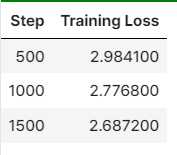

이제 문장 생성 능력을 확인하기 위해  
빠르게 허깅페이스의 pipleline 클래스를 사용하여 generator를 만들어보기

In [75]:
# 텍스트 생성 파이프라인 생성
'''
Hugging Face의 pipeline을 사용하여 텍스트 생성 파이프라인을 생성합니다.
- text-generation은 텍스트 생성 작업을 수행하는 파이프라인을 지정합니다.
- model 인자에는 텍스트를 생성할 모델의 경로를 지정합니다.
- tokenizer 인자에는 사용할 토크나이저를 지정합니다.
'''
generator = pipeline('text-generation', model='/aiffel/KoChatGPT/output_1_SFT', tokenizer=tokenizer)

# 텍스트 생성 매개변수 설정
'''
텍스트 생성에 사용할 매개변수를 설정합니다. 각 매개변수에 대한 설명은 아래와 같습니다:
- num_beams: 빔 검색의 너비입니다. 생성 시 빔 검색을 사용하여 생성합니다.
- repetition_penalty: 반복 페널티 값입니다. 반복되는 텍스트를 피하기 위해 사용됩니다.
- no_repeat_ngram_size: 반복을 방지할 n-gram 크기입니다.
- eos_token_id: 종료 토큰의 ID입니다. 생성된 텍스트의 종료를 나타냅니다.
- max_new_tokens: 최대 생성 토큰 수입니다.
- do_sample: 샘플링 여부를 결정합니다.
- top_k: 상위 k개의 토큰만 고려하여 샘플링합니다.
- early_stopping: 생성이 완료되면 조기 종료할지 여부를 결정합니다.
'''
generation_args = dict(   
    num_beams=4,
    repetition_penalty=2.0,
    no_repeat_ngram_size=4,
    eos_token_id=375, # \n   
    max_new_tokens=64,
    do_sample=True,
    top_k=50,
    early_stopping=True
)

PROMPT_DICT = {
    "prompt_input": (
        "### Instruction(명령어):\n{prompt}\n\n### Response(응답):"
    )
}

# 프롬프트 생성
# 생성할 텍스트의 프롬프트를 지정합니다. 각 프롬프트는 PROMPT_DICT에 따라 포맷되어야 합니다.
list_prompt = ['불고기용 고기 한우에요?',
               '리처드 닉슨이 43대 부통령직을 수행한 년도는?',
               '시카고 오헤어 국제공항은 어디에 있어?',
               '오늘 미세먼지 어때?']

list_prompt = [PROMPT_DICT['prompt_input'].format_map({'prompt' : tmp}) for tmp in list_prompt]

# 텍스트 생성 및 결과 출력
'''
생성기를 사용하여 각 프롬프트에 대한 텍스트를 생성하고, 결과를 출력합니다.
generator에는 생성할 프롬프트와 매개변수가 전달됩니다.
list_result에는 각 프롬프트에 대한 생성된 텍스트가 포함됩니다.
zip을 사용하여 프롬프트와 생성된 결과를 묶고, 각각을 출력합니다.
'''
list_result = generator(list_prompt, **generation_args)   
for prompt, result in zip(list_prompt, list_result):
    print()
    print((result[0]['generated_text']))

/opt/conda/lib/python3.9/site-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(



### Instruction(명령어):
불고기용 고기 한우에요?

### Response(응답):'저는 인공지능 어시스턴트이기 때문에 고기를 먹을 수는 없습니다. 하지만 일반적으로 불고기용 고기는 돼지고기나 소고기, 닭고기, 오리고기 등 다양한 요리에 사용됩니다. 그러나 일부 음식점에서는 불고기용 고기를 판매하기도 합니다.禪師, physical capabil

### Instruction(명령어):
리처드 닉슨이 43대 부통령직을 수행한 년도는?

### Response(응답):'리처드 닉슨은 46대 부통령직을 수행했습니다.詳品: "리처드 닉슨" (Christian Nixon)詳品은 "리처드 닉슨" (Richard Dynamics)이다.詳品)은 "리처드슨" (Charles Dynamic

### Instruction(명령어):
시카고 오헤어 국제공항은 어디에 있어?

### Response(응답):'시카고 오 헤어 국제공항은 미국 캘리포니아주 샌프란시스코에 위치해 있습니다.詳識)에 따르면, 시카고는 미국에서 가장 큰 국제공항 중 하나입니다.詳識)에는 "시카고 오헤이어 국제공항"이 포함되어 있습니다.相識)에는 "오헤어 국제공항"이라는 용어가 사용됩니다.詳識에는 "

### Instruction(명령어):
오늘 미세먼지 어때?

### Response(응답):'미세먼지 예보는 매우 중요합니다. 미세먼지 예보를 위해서는 다음과 같은 방법이 있습니다.\n\n1. 실내 공기청정기 사용: 실내 공기청정기를 사용하여 실내 공기를 깨끗하게 유지하는 것이 좋습니다.\n2. 인공지능 언어모델: 미세먼지 정보를 기반으로 답변을 생성하는 프로그램입니다.\


Origianl generator answers

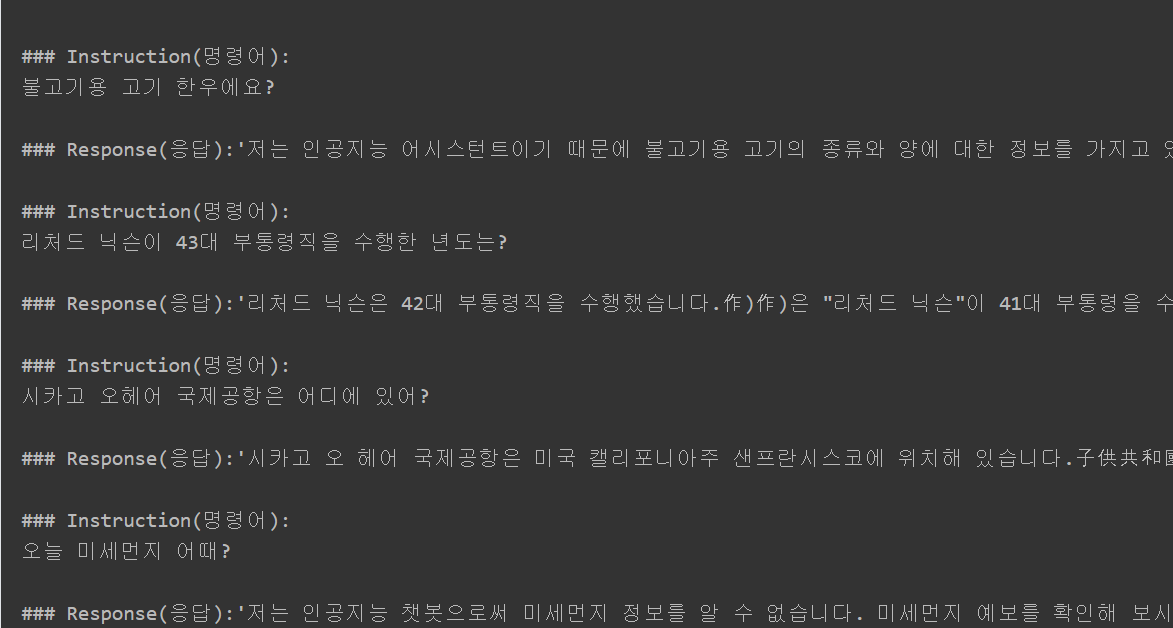

[Text generation strategies](https://huggingface.co/docs/transformers/v4.28.1/en/generation_strategies)

SFT 단계를 최적화하기 위해선 무엇보다도 instruction dataset의 품질과 initial모델의 언어모델링 성능이 중요하다.  

메모리 관리를 위해 캐시를 비우고 넘어가기

In [76]:
torch.cuda.empty_cache()

# 회고

- 간단한 전처리를 진행하고 눈에 띄는 변화가 있나 살펴보았지만, 역시 크게 달라지지 않았다. 조금 더 전처리를 진행해서 성능의 변화를 살펴보아야겠다. 


# 참고
- [generator 관련 참고](https://hipster4020.tistory.com/194)